# Modeling IoT Malware Classification using XGBoost

Final Model metrics:
* F1                          0.985140
* roc_auc_score               0.984291
* Accuracy                    0.980943
* Recall                      0.973070
* Precision                   0.997514
* Brier Skill Score           0.969994
* Cohen Kappa Score           0.958594
* Average Precision Score     0.988133
* Balanced Accuracy Score     0.984291
* FBeta Score where Beta=2    0.977863



In [26]:
# built in modules
from datetime import datetime
time_start_notebook =  datetime.now()
# import os
import sys
import importlib

# PIP modules
import pandas as pd
# import numpy as np
import seaborn as sns
from   sklearn.model_selection import train_test_split # GridSearchCV, cross_validate, 
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from   xgboost import XGBClassifier

# My custom Python module
######################### DON'T TOUCH ANYTHING BELOW #########################
newpath = '..'
if not newpath in sys.path:
    sys.path.insert(1, newpath)
del newpath
import tim_ml_lib as tml    # works
importlib.reload(tml)     # reload it since I'm frequently making changes.
######################### DON'T TOUCH ANYTHING ABOVE #########################

# some common, basic setup
tml.initialize_random_seeds()
tml.initialize_display_options()

# Model Options

In [27]:
INPUT_FILEPATH      = './data/CTU-IoT-Malware-Capture_ready2train.csv.gz'
LABEL_COLUMN_NAME   = 'is_IoT_malware'
PRIMARY_METRIC      = 'F1'                      # key from 'scoring' dict
TEST_SIZE           = 0.3
# CV                  = 9

# The beta parameter represents the ratio of recall importance to precision importance.
# beta > 1 gives more weight to recall, while beta < 1 favors precision. For example,
# beta = 2 makes recall twice as important as precision,
# while beta = 0.5 does the opposite
F_SCORE_BETA        = 2

RANDOM_STATE        = tml.settings.RANDOM_STATE
N_JOBS              = tml.get_ideal_num_jobs()  # number of CPU cores to use
ZERO_DIVISION_VALUE = 0                         #

scoring = {
    "F1":                 skm.make_scorer(skm.f1_score, zero_division=ZERO_DIVISION_VALUE),                  
    "Accuracy":           'accuracy',  
    "Recall":             skm.make_scorer(skm.recall_score, zero_division=ZERO_DIVISION_VALUE),  
    "Precision":          skm.make_scorer(skm.precision_score, zero_division=ZERO_DIVISION_VALUE),             
    "roc_auc":            "roc_auc",  
    "roc_auc_score":      skm.make_scorer(skm.roc_auc_score),    
    "neg_log_loss":       "neg_log_loss",  
    "Brier Score Loss":   skm.make_scorer(skm.brier_score_loss),  
    }

FLOAT_DATATYPE = 'float32[pyarrow]'     

TRAINING_DATATYPES = {
    'is_IoT_malware':      'uint8[pyarrow]',    # label   
    'duration':            FLOAT_DATATYPE,      # float b/c of standardization
    'orig_pkts':           FLOAT_DATATYPE,      # float b/c of standardization   
    'hour_of_day':         FLOAT_DATATYPE,      # added feature - values ranges from [0,23]
    'src_port_range_name': 'uint8[pyarrow]',    # added feature - values ranges from [0,4]
    'orig_ip_bytes':       FLOAT_DATATYPE,
    'proto_icmp':          'uint8[pyarrow]',
    'proto_tcp':           'uint8[pyarrow]',
    'proto_udp':           'uint8[pyarrow]'
}

In [28]:
df = pd.read_csv(INPUT_FILEPATH,
                delimiter=',',
                # engine='pyarrow',# chunksize isn't supported by pyarrow
                engine='c',
                dtype=TRAINING_DATATYPES,
                header=0,
                nrows=3000001) # reduced runtime from 41 sec to 4.7 sec

# df = df.sample(n=3000001, random_state=RANDOM_STATE)

y  = df[LABEL_COLUMN_NAME]
X  = df.drop(columns=LABEL_COLUMN_NAME, axis=1)

print(f'Dataframe chunk shape: {df.shape}')
print(f'Dataframe size in memory: {tml.get_total_dataframe_memory_usage(df)}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

Dataframe chunk shape: (3000001, 9)
Dataframe size in memory: 63.0 MB
X shape: (3000001, 8)
y shape: (3000001,)


# Single model, not Grid Search

In [29]:
final_model = XGBClassifier(
        objective='binary:logistic',
        random_state=RANDOM_STATE,
        max_depth=2,
        n_estimators=100,
        learning_rate=0.9,
        )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

final_model.fit(X_train, y_train)
num_predictions = X_test.shape[0]
y_pred = final_model.predict(X_test)

# scores_train = cross_validate(final_model, X_train, y_train, cv=CV, scoring=scoring, n_jobs=N_JOBS)
# print(y_test.shape)
# print(y_pred.shape)

In [30]:
scores_test = {}

scores_test['F1']                      = skm.f1_score(y_test, y_pred)
scores_test['roc_auc_score']           = skm.roc_auc_score(y_test, y_pred)
scores_test['Accuracy']                = skm.accuracy_score(y_test, y_pred)
scores_test['Recall']                  = skm.recall_score(y_test, y_pred)
scores_test['Precision']               = skm.precision_score(y_test, y_pred)
scores_test['Brier Skill Score']       = tml.brier_skill_score(y_test, y_pred)
scores_test['Cohen Kappa Score']       = skm.cohen_kappa_score(y_test, y_pred)
scores_test['Average Precision Score'] = skm.average_precision_score(y_test, y_pred)
scores_test['Balanced Accuracy Score'] = skm.balanced_accuracy_score(y_test, y_pred)

scores_test[f'FBeta Score where Beta={F_SCORE_BETA}']      = skm.fbeta_score(y_test, y_pred, beta=F_SCORE_BETA)

# scores_test['Log Loss']                = skm.log_loss(y_test, y_pred)
# scores_test['d2_log_loss_score']       = skm.d2_log_loss_score(y_test, y_pred)
# scores_test['hamming_loss']            = skm.hamming_loss(y_test, y_pred)
# scores_test['hinge_loss']              = skm.hinge_loss(y_test, y_pred)
# scores_test['jaccard_score']           = skm.jaccard_score(y_test, y_pred)
# scores_test['Zero One Loss']           = skm.zero_one_loss(y_test, y_pred)

s_perf = pd.Series(scores_test)
s_perf

F1                          0.985787
roc_auc_score               0.985450
Accuracy                    0.981782
Recall                      0.973156
Precision                   0.998749
Brier Skill Score           0.971315
Cohen Kappa Score           0.960435
Average Precision Score     0.989366
Balanced Accuracy Score     0.985450
FBeta Score where Beta=2    0.978169
dtype: float64

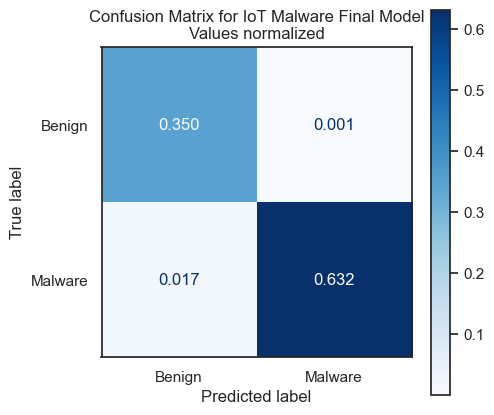

In [31]:
sns.set_theme(style="white")    # the default theme causes minor issues with Confusion Matrix

# using this version for better display options, even though it is slower
cm_fig = skm.ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test,
                            cmap='Blues',
                            normalize='all',  # 'true', 'pred', 'all' or None
                            display_labels=['Benign', 'Malware'],
                            values_format='0.3f'
                            )

plt.title('Confusion Matrix for IoT Malware Final Model\nValues normalized')
plt.show()

In [32]:
print(skm.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.953     0.998     0.975    315737
         1.0      0.999     0.973     0.986    584264

    accuracy                          0.982    900001
   macro avg      0.976     0.985     0.980    900001
weighted avg      0.983     0.982     0.982    900001



# Analyzing speed / runtime

In [33]:
print(num_predictions)
%timeit -n 1 -r 20 y_pred = final_model.predict(X_test)
# 59.4 ms / 900001 samples = 0.000000065333261 seconds per sample = 15,306,139 samples per second

900001


In [ ]:
%timeit -n 100 -r 10 final_model.predict(X_test.iloc[:1])
# 573 μs ± 42.6 μs per loop (mean ± std. dev. of 10 runs, 100 loops each) = 0.000573 seconds -> 1745 samples per second

583 μs ± 53.1 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## Analyzing memory utilization
* pympler.asizeof says 5 kilobytes
* pickle says 94 kilobytes

In [ ]:
# %pip install pympler
from pympler.asizeof import asizeof
# sys.getsizeof(final_model)  # very inaccurate
asizeof(final_model)    # 5168 bytes

Note: you may need to restart the kernel to use updated packages.


5152

In [ ]:
import pickle
with open('final_model.pickle', "wb") as f:
    pickle.dump(final_model, f)

In [ ]:
time_end_notebook =  datetime.now()
print(time_end_notebook - time_start_notebook)